Dataset shape: (2015, 15)

Columns: ['Domain', 'Having_@_symbol', 'Having_IP', 'Prefix_suffix_separation', 'Redirection_//_symbol', 'Sub_domains', 'URL_Length', 'age_domain', 'dns_record', 'domain_registration_length', 'http_tokens', 'label', 'statistical_report', 'tiny_url', 'web_traffic']

Class distribution:
label
0    1017
1     998
Name: count, dtype: int64

Training Random Forest...
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       320
           1       0.86      0.79      0.82       285

    accuracy                           0.84       605
   macro avg       0.84      0.84      0.84       605
weighted avg       0.84      0.84      0.84       605


Training Naive Bayes...
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.55      1.00      0.71       320
           1       1.00      0.07      0.14       285

    accuracy        

,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC,Training Time (s)
Model,,,,,,,
Random Forest,0.838017,0.855513,0.789474,0.821168,0.896875,0.869023,0.414896
Naive Bayes,0.563636,1.000000,0.073684,0.137255,0.843405,0.823441,0.002278
Logistic Regression,0.742149,0.732852,0.712281,0.722420,0.832297,0.825650,0.007407
SVM,0.798347,0.802974,0.757895,0.779783,0.886716,0.866145,0.556994


<Figure size 1500x800 with 0 Axes>

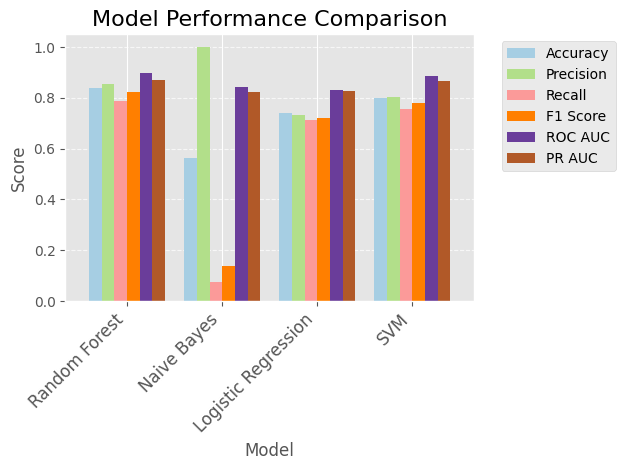

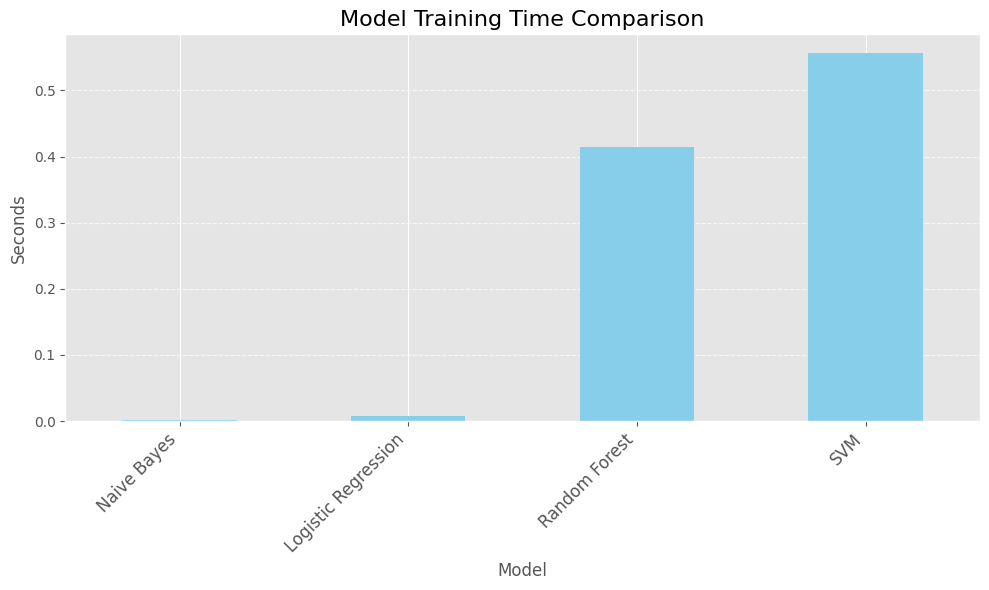

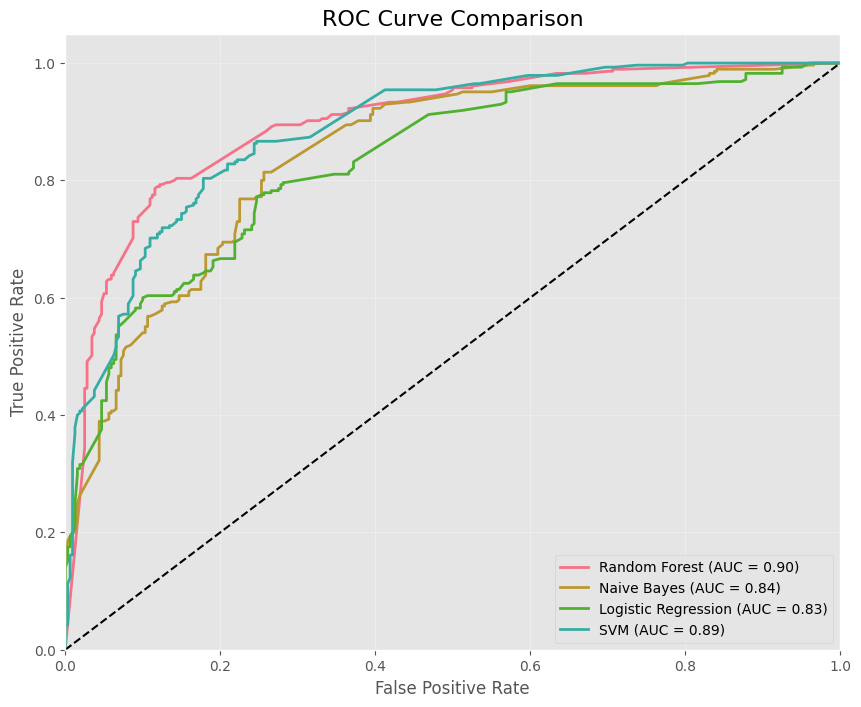

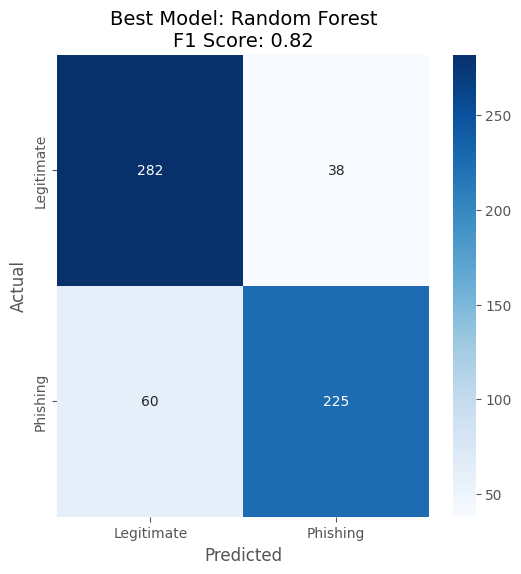

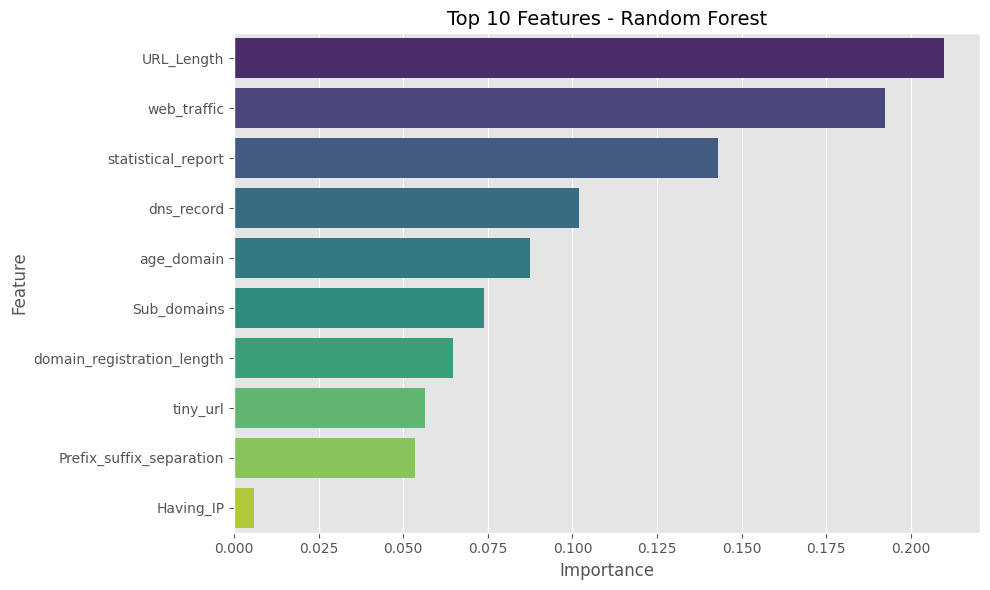


Best Model based on F1 Score: Random Forest
Best Model Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           confusion_matrix, classification_report, roc_curve, auc,
                           precision_recall_curve, average_precision_score, roc_auc_score)
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Set style for visualizations
plt.style.use('ggplot')
sns.set_palette("husl")

# Load datasets
phishing_df = pd.read_csv("G:/Phishing-Website-Detection/Phishing website detection using UI/phishing-urls.csv")
legitimate_df = pd.read_csv("G:/Phishing-Website-Detection/Phishing website detection using UI/legitimate-urls.csv")

# Add labels
phishing_df['label'] = 1  # 1 for phishing
legitimate_df['label'] = 0  # 0 for legitimate

# Combine and shuffle datasets
df = pd.concat([phishing_df, legitimate_df], axis=0).sample(frac=1).reset_index(drop=True)

# Drop unnecessary columns
df = df.drop(['Path', 'Protocol'], axis=1, errors='ignore')

# Check data
print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nClass distribution:")
print(df['label'].value_counts())

# Separate features and target
X = df.drop(['Domain', 'label'], axis=1)  # Drop Domain as we'll use other features
y = df['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models (XGBoost removed)
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "SVM": SVC(random_state=42, probability=True)
}

# Dictionary to store results
results = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'ROC AUC': [],
    'PR AUC': [],
    'Training Time (s)': []
}

# Train and evaluate models
for name, model in models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    
    model.fit(X_train_scaled, y_train)
    train_time = time.time() - start_time
    
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Store metrics
    results['Model'].append(name)
    results['Accuracy'].append(accuracy_score(y_test, y_pred))
    results['Precision'].append(precision_score(y_test, y_pred))
    results['Recall'].append(recall_score(y_test, y_pred))
    results['F1 Score'].append(f1_score(y_test, y_pred))
    results['ROC AUC'].append(roc_auc_score(y_test, y_proba))
    results['PR AUC'].append(average_precision_score(y_test, y_proba))
    results['Training Time (s)'].append(train_time)
    
    print(f"{name} Classification Report:")
    print(classification_report(y_test, y_pred))

# Convert results to DataFrame
results_df = pd.DataFrame(results).set_index('Model')

# 1. Metrics Comparison Table
print("\nModel Comparison Table:")
display(results_df.style.background_gradient(cmap='Blues', subset=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'PR AUC']))

# 2. Metrics Comparison Visualization
plt.figure(figsize=(15, 8))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'PR AUC']
results_df[metrics].plot(kind='bar', width=0.8, colormap='Paired')
plt.title('Model Performance Comparison', fontsize=16)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3. Training Time Comparison
plt.figure(figsize=(10, 6))
results_df['Training Time (s)'].sort_values().plot(kind='bar', color='skyblue')
plt.title('Model Training Time Comparison', fontsize=16)
plt.ylabel('Seconds', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 4. ROC Curve Comparison
plt.figure(figsize=(10, 8))
for name, model in models.items():
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison', fontsize=16)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.show()

# 5. Confusion Matrix for Best Model (now Random Forest)
best_model_name = results_df['F1 Score'].idxmax()
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Legitimate', 'Phishing'], 
            yticklabels=['Legitimate', 'Phishing'])
plt.title(f'Best Model: {best_model_name}\nF1 Score: {results_df.loc[best_model_name, "F1 Score"]:.2f}', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.show()

# 6. Feature Importance for Random Forest only (since XGBoost was removed)
if 'Random Forest' in models:
    plt.figure(figsize=(10, 6))
    model = models['Random Forest']
    importances = model.feature_importances_
    feat_imp = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False).head(10)
    
    sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')
    plt.title('Top 10 Features - Random Forest', fontsize=14)
    plt.tight_layout()
    plt.show()

print("\nBest Model based on F1 Score:", best_model_name)
print("Best Model Parameters:", best_model.get_params())